In [5]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# 8. 

_문제: 선형적으로 분리되는 데이터셋에 `LinearSVC`를 훈련시켜보세요. 그런 다음 같은 데이터셋에 `SVC`와`SGDClassifier`를 적용해보세요. 거의 비슷한 모델이 만들어지는지 확인해보세요._

Iris 데이터셋을 사용하겠습니다. Iris Setosa와 Iris Versicolor 클래스는 선형적으로 구분이 가능합니다.

In [6]:
from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:, (2, 3)]  # 꽃잎 길이, 꽃잎 너비
y = iris["target"]

setosa_or_versicolor = (y == 0) | (y == 1)
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

In [7]:
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler

C = 5
alpha = 1 / (C * len(X))

lin_clf = LinearSVC(loss="hinge", C=C, random_state=42)
svm_clf = SVC(kernel="linear", C=C)
sgd_clf = SGDClassifier(loss="hinge", learning_rate="constant", eta0=0.001, alpha=alpha,
                        max_iter=1000, tol=1e-3, random_state=42)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

lin_clf.fit(X_scaled, y)
svm_clf.fit(X_scaled, y)
sgd_clf.fit(X_scaled, y)

print("LinearSVC:                   ", lin_clf.intercept_, lin_clf.coef_)
print("SVC:                         ", svm_clf.intercept_, svm_clf.coef_)
print("SGDClassifier(alpha={:.5f}):".format(sgd_clf.alpha), sgd_clf.intercept_, sgd_clf.coef_)

LinearSVC:                    [0.28475098] [[1.05364854 1.09903804]]
SVC:                          [0.31896852] [[1.1203284  1.02625193]]
SGDClassifier(alpha=0.00200): [0.117] [[0.77714169 0.72981762]]


이 3개 모델의 결정 경계를 그려 보겠습니다:

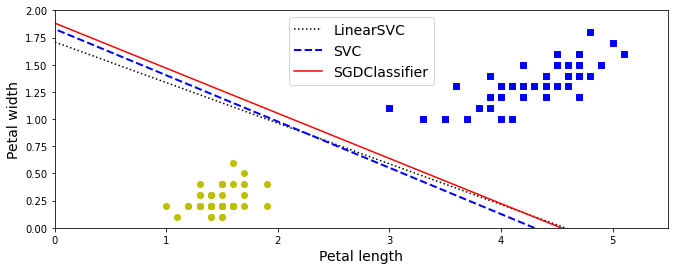

In [8]:
# 각 결정 경계의 기울기와 편향을 계산합니다
w1 = -lin_clf.coef_[0, 0]/lin_clf.coef_[0, 1]
b1 = -lin_clf.intercept_[0]/lin_clf.coef_[0, 1]
w2 = -svm_clf.coef_[0, 0]/svm_clf.coef_[0, 1]
b2 = -svm_clf.intercept_[0]/svm_clf.coef_[0, 1]
w3 = -sgd_clf.coef_[0, 0]/sgd_clf.coef_[0, 1]
b3 = -sgd_clf.intercept_[0]/sgd_clf.coef_[0, 1]

# 결정 경계를 원본 스케일로 변환합니다
line1 = scaler.inverse_transform([[-10, -10 * w1 + b1], [10, 10 * w1 + b1]])
line2 = scaler.inverse_transform([[-10, -10 * w2 + b2], [10, 10 * w2 + b2]])
line3 = scaler.inverse_transform([[-10, -10 * w3 + b3], [10, 10 * w3 + b3]])

# 세 개의 결정 경계를 모두 그립니다
plt.figure(figsize=(11, 4))
plt.plot(line1[:, 0], line1[:, 1], "k:", label="LinearSVC")
plt.plot(line2[:, 0], line2[:, 1], "b--", linewidth=2, label="SVC")
plt.plot(line3[:, 0], line3[:, 1], "r-", label="SGDClassifier")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs") # label="Iris versicolor"
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo") # label="Iris setosa"
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper center", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()

아주 비슷!

# 9. 

_문제: MNIST 데이터셋에 SVM 분류기를 훈련시켜보세요. SVM 분류기는 이진 분류기라서 OvA 전략을 사용해 10개의 숫자를 분류해야 합니다. 처리 속도를 높이기 위해 작은 검증 세트로 하이퍼파라미터를 조정하는 것이 좋습니다. 어느 정도까지 정확도를 높일 수 있나요?_

먼저 데이터셋을 로드하고 훈련 세트와 테스트 세트로 나눕니다. `train_test_split()` 함수를 사용할 수 있지만 보통 처음 60,000개의 샘플을 훈련 세트로 사용하고 나머지는 10,000개를 테스트 세트로 사용합니다(이렇게 하면 다른 사람들의 모델과 성능을 비교하기 좋습니다):

In [9]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, cache=True)

X = mnist["data"]
y = mnist["target"].astype(np.uint8)

X_train = X[:60000]
y_train = y[:60000]
X_test = X[60000:]
y_test = y[60000:]

많은 훈련 알고리즘은 훈련 샘플의 순서에 민감하므로 먼저 이를 섞는 것이 좋은 습관입니다. 하지만 이 데이터셋은 이미 섞여있으므로 이렇게 할 필요가 없습니다.

선형 SVM 분류기부터 시작해보죠. 이 모델은 자동으로 OvA(또는 OvR) 전략을 사용하므로 특별히 처리해 줄 것이 없습니다. 간단하네요!

**경고**: 이 작업은 하드웨어에 따라 몇 분이 걸릴 수 있습니다.

In [11]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train, y_train)

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(random_state=42)

훈련 세트에 대한 예측을 만들어 정확도를 측정해 보겠습니다(최종 모델을 선택해 훈련시킨 것이 아니기 때문에 아직 테스트 세트를 사용해서는 안됩니다):

In [12]:
from sklearn.metrics import accuracy_score

y_pred = lin_clf.predict(X_train)
accuracy_score(y_train, y_pred)

0.8348666666666666

MNIST에서 83.5% 정확도면 나쁜 성능입니다. 선형 모델이 MNIST 문제에 너무 단순하기 때문이지만 먼저 데이터의 스케일을 조정할 필요가 있습니다:

In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float32))
X_test_scaled = scaler.transform(X_test.astype(np.float32))

**경고**: 이 작업은 하드웨어에 따라 몇 분이 걸릴 수 있습니다.

In [14]:
lin_clf = LinearSVC(random_state=42)
lin_clf.fit(X_train_scaled, y_train)

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC(random_state=42)

In [15]:
y_pred = lin_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9214

훨씬 나아졌지만(에러율을 절반으로 줄였습니다) 여전히 MNIST에서 좋은 성능은 아닙니다. SVM을 사용한다면 커널 함수를 사용해야 합니다. RBF 커널(기본값)로 `SVC`를 적용해 보겠습니다.

**노트**: 향후 버전을 위해 사이킷런 0.22에서 기본값인 `gamma="scale"`을 지정합니다.

In [16]:
svm_clf = SVC(gamma="scale")
svm_clf.fit(X_train_scaled[:10000], y_train[:10000])

SVC()

In [17]:
y_pred = svm_clf.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9455333333333333

아주 좋네요 6배나 적은 데이터에서 모델을 훈련시켰지만 더 좋은 성능을 얻었습니다. 교차 검증을 사용한 랜덤 서치로 하이퍼파라미터 튜닝을 해보겠습니다. 진행을 빠르게 하기 위해 작은 데이터셋으로 작업하겠습니다:

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(svm_clf, param_distributions, n_iter=10, verbose=2, cv=3)
rnd_search_cv.fit(X_train_scaled[:1000], y_train[:1000])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .....C=9.287371469929122, gamma=0.05916560917438858; total time=   0.3s
[CV] END .....C=9.287371469929122, gamma=0.05916560917438858; total time=   0.2s
[CV] END .....C=9.287371469929122, gamma=0.05916560917438858; total time=   0.2s
[CV] END ....C=4.554549779881886, gamma=0.005921922660267048; total time=   0.2s
[CV] END ....C=4.554549779881886, gamma=0.005921922660267048; total time=   0.2s
[CV] END ....C=4.554549779881886, gamma=0.005921922660267048; total time=   0.2s
[CV] END ...C=1.8225424434994888, gamma=0.005372848324174189; total time=   0.2s
[CV] END ...C=1.8225424434994888, gamma=0.005372848324174189; total time=   0.2s
[CV] END ...C=1.8225424434994888, gamma=0.005372848324174189; total time=   0.2s
[CV] END ....C=8.768536815117994, gamma=0.027612555728259443; total time=   0.2s
[CV] END ....C=8.768536815117994, gamma=0.027612555728259443; total time=   0.2s
[CV] END ....C=8.768536815117994, gamma=0.027612

RandomizedSearchCV(cv=3, estimator=SVC(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FF414BFEE0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FF3B5FEA40>},
                   verbose=2)

In [19]:
rnd_search_cv.best_estimator_

SVC(C=4.955357418245199, gamma=0.0022631454216076002)

In [20]:
rnd_search_cv.best_score_

0.8489867112621603

이 점수는 낮지만 1,000개의 샘플만 사용한 것을 기억해야 합니다. 전체 데이터셋으로 최선의 모델을 재훈련시켜 보겠습니다:

**경고**: 사용하는 하드웨어에 따라 다음 셀을 실행하는데 몇 시간이 걸릴 수 있습니다.

In [21]:
rnd_search_cv.best_estimator_.fit(X_train_scaled, y_train)

SVC(C=4.955357418245199, gamma=0.0022631454216076002)

In [22]:
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
accuracy_score(y_train, y_pred)

0.9994166666666666

아주 훌륭하네요! 이 모델을 선택하겠습니다. 이제 테스트 세트로 모델을 테스트합니다:

In [23]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
accuracy_score(y_test, y_pred)

0.9687

아주 나쁘지 않지만 확실히 모델이 다소 과대적합되었습니다. 

하이퍼파라미터를 조금 더 수정할 수 있지만(가령, `C`와/나 `gamma`를 감소시킵니다) 

그렇게 하면 테스트 세트에 과대적합될 위험이 있습니다. 다른 사람들은 

하이퍼파라미터 `C=5`와 `gamma=0.005`에서 더 나은 성능(98% 이상의 정확도)을 얻었습니다. 

훈련 세트를 더 많이 사용해서 더 오래 랜덤 서치를 수행하면 이런 값을 얻을 수 있을지 모릅니다.

## 10. _문제: 캘리포니아 주택 가격 데이터셋에 SVM 회귀를 훈련시켜보세요._

사이킷런의 `fetch_california_housing()` 함수를 사용해 데이터셋을 로드합니다:

In [24]:
from sklearn.datasets import fetch_california_housing

housing = fetch_california_housing()
X = housing["data"]
y = housing["target"]

훈련 세트와 테스트 세트로 나눕니다:

In [25]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

데이터의 스케일을 조정하는 것을 잊지 마세요:

In [26]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

먼저 간단한 `LinearSVR`을 훈련시켜 보죠:

In [27]:
from sklearn.svm import LinearSVR

lin_svr = LinearSVR(random_state=42)
lin_svr.fit(X_train_scaled, y_train)

C:\Anaconda3\envs\tf_pt\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVR(random_state=42)

훈련 세트에 대한 성능을 확인해 보겠습니다:

In [28]:
from sklearn.metrics import mean_squared_error

y_pred = lin_svr.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
mse

0.9641780189948642

RMSE를 확인해 보겠습니다:

In [29]:
np.sqrt(mse)

0.9819256687727764

훈련 세트에서 타깃은 만달러 단위입니다. RMSE는 기대할 수 있는 에러의 정도를 대략 가늠하게 도와줍니다

(에러가 클수록 큰 폭으로 증가합니다). 이 모델의 에러가 대략 $10,000 정도로 예상할 수 있습니다. 

썩 훌륭하지 않네요. RBF 커널이 더 나을지 확인해 보겠습니다. 하이퍼파라미터 `C`와 `gamma`의 적절한 값을 

찾기 위해 교차 검증을 사용한 랜덤 서치를 적용하겠습니다:

In [30]:
from sklearn.svm import SVR
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import reciprocal, uniform

param_distributions = {"gamma": reciprocal(0.001, 0.1), "C": uniform(1, 10)}
rnd_search_cv = RandomizedSearchCV(SVR(), param_distributions, n_iter=10, verbose=2, cv=3, random_state=42)
rnd_search_cv.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END .....C=4.745401188473625, gamma=0.07969454818643928; total time=  11.8s
[CV] END .....C=4.745401188473625, gamma=0.07969454818643928; total time=  11.8s
[CV] END .....C=4.745401188473625, gamma=0.07969454818643928; total time=  11.8s
[CV] END .....C=8.31993941811405, gamma=0.015751320499779724; total time=  11.7s
[CV] END .....C=8.31993941811405, gamma=0.015751320499779724; total time=  11.5s
[CV] END .....C=8.31993941811405, gamma=0.015751320499779724; total time=  11.6s
[CV] END ....C=2.560186404424365, gamma=0.002051110418843397; total time=  11.4s
[CV] END ....C=2.560186404424365, gamma=0.002051110418843397; total time=  11.9s
[CV] END ....C=2.560186404424365, gamma=0.002051110418843397; total time=  11.9s
[CV] END ....C=1.5808361216819946, gamma=0.05399484409787431; total time=  11.1s
[CV] END ....C=1.5808361216819946, gamma=0.05399484409787431; total time=  11.0s
[CV] END ....C=1.5808361216819946, gamma=0.05399

RandomizedSearchCV(cv=3, estimator=SVR(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FF414A5DE0>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x000001FF414A7580>},
                   random_state=42, verbose=2)

In [31]:
rnd_search_cv.best_estimator_

SVR(C=4.745401188473625, gamma=0.07969454818643928)

이제 훈련 세트에서 RMSE를 측정해 보겠습니다:

In [32]:
y_pred = rnd_search_cv.best_estimator_.predict(X_train_scaled)
mse = mean_squared_error(y_train, y_pred)
np.sqrt(mse)

0.5727524770785372

선형 모델보다 훨씬 나아졌네요. 이 모델을 선택하고 테스트 세트에서 평가해 보겠습니다:

In [33]:
y_pred = rnd_search_cv.best_estimator_.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
np.sqrt(mse)

0.5929168385528758